# Estimación de ruido mediante análisis del histograma

In [21]:
import numpy as np
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Leemos la data extraida del slice

In [22]:
data_path = 'infosaves'
with open(rf"infosaves/100.0_100.0_253x263.json") as f:
    stats = json.load(f)
stats

{'nombre_img': '100.0_100.0_253x263',
 'altura': 253,
 'width': 263,
 'varianza': 148.0590359989778,
 'mean': 15.669892844797788}

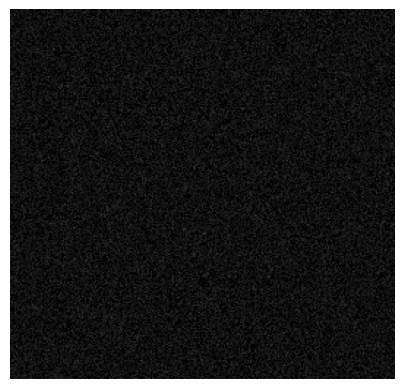

In [23]:
img_ruido = np.random.normal(loc=stats['mean'], 
                             scale=np.sqrt(stats['varianza']),
                             size=(stats['altura'], stats['width']))
plt.imshow(img_ruido, vmin=0, vmax=255, cmap='gray')
plt.axis('off')
plt.show()

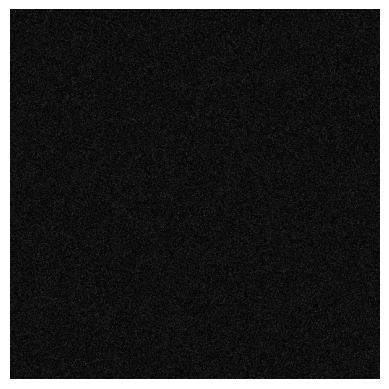

In [24]:
ruido = cv2.imread('PAIByB-1/Noise-1.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(ruido, vmin=0, vmax=255, cmap='gray')
plt.axis('off')
plt.show()

### Ahora, con el histograma

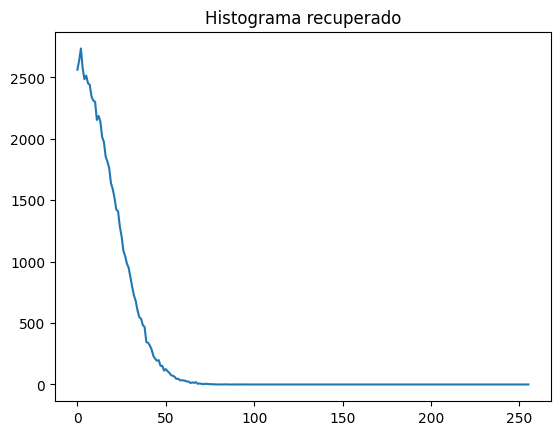

In [26]:
hist_df = pd.read_csv(f"infosaves/hist100.0_100.0_253x263.csv")
plt.plot(hist_df['gray_lvl'], hist_df['hist_value'])
plt.title('Histograma recuperado')
plt.show()

In [25]:
print('bueno listo me voy a mear arreglense usetedes yo solo los puedo ayudar a volar esto es ysy a ysuena as')

bueno listo me voy a mear arreglense usetedes yo solo los puedo ayudar a volar esto es ysy a ysuena as


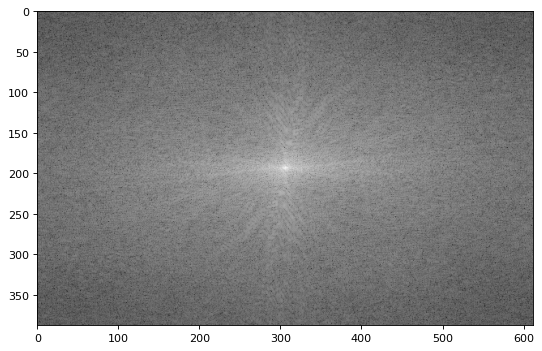

In [31]:
img = cv2.imread('PAIByB-2/Pie2-1.tif',cv2.IMREAD_GRAYSCALE)

img_ft = np.fft.fftshift(np.fft.fft2(img))

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(img_ft)), cmap='gray')
plt.show()

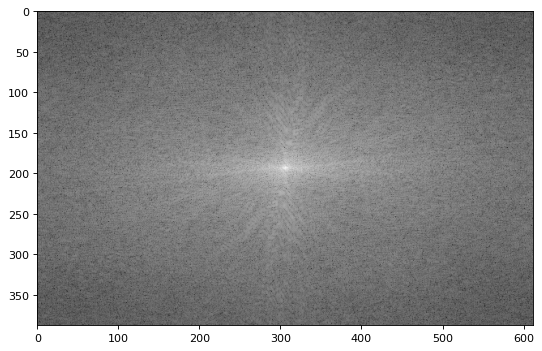

In [32]:
img_sp = np.power(img_ft,2)

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(img_sp)), cmap='gray')
plt.show()